In [48]:
import os
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from scipy.stats import randint
import numpy as np
import requests
from datetime import datetime
from dateutil.relativedelta import relativedelta
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.power import TTestIndPower
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, precision_recall_curve, auc, roc_curve
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
sns.set()
from scipy import stats
from scipy import special
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
v=10996179
np.random.seed(v)

In [2]:
# Importing data and adding GDP column to it
df_overall = pd.read_csv("df_combined.csv")
gdp=pd.read_excel('GDP_per_capita.xlsx')
gdp['mean']=gdp.iloc[:, 1:].mean(axis=1)
df_overall=pd.merge(df_overall, gdp.iloc[:, [0,-1]], how='left', left_on=['country'], right_on=['Country Code'])
df_overall.head()

,fide_id,country,name,flag,Ratings_nov22,Games_nov22,Title_nov22,Ratings_aug12,Games_aug12,Title_aug12,...,Title_apr20,Ratings_JUL06,Games_JUL06,Title_JUL06,Ratings_jul12,Games_jul12,Title_jul12,Dob,Country Code,mean
0,8519790,NaN,NGR M,NaN,1834,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
1,25121731,IND,A C J John,i,1063,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1987,IND,602.633167
2,35077023,IND,A Chakravarthy,i,1151,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1986,IND,602.633167
3,10207538,BAN,"A E M, Doshtagir",i,1840,0,NaN,1864.0,0.0,NaN,...,NaN,NaN,NaN,NaN,1864.0,0.0,NaN,1974,NaN,NaN
4,10680810,EGY,"A hamed Ashraf, Abdallah",i,1728,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001,EGY,1279.448386


In [3]:
# Creating Age columns for users by month
col=df_overall.columns
col=np.array(col)

yr=list([])
yr1=list([])
mth=list([])
for  i in col:
    if 'Ratings_' in i:
        yr.append(i[-2:])
        yr1.append(int('20' + i[-2:]))
        mth.append(i[-5:-2])


month=list([])
for i in range(len(mth)):
    mname = mth[i]
    mnum = datetime.strptime(mname, '%b').month
    month.append(mnum)

for i in range(len(yr)):
    df_overall[('Age_' + mth[i] + yr[i])]=yr1[i] - np.array(df_overall.loc[:,'Dob'])

# Clustering

In [4]:
# Removing duplicates and reseting index
metadata_columns = ["fide_id", "country", "flag", "Title_nov22", "Dob"]

df_cluster=df_overall.iloc[:,[0,6]]

df_cluster['Dob']=df_overall['Dob']
df_cluster=df_cluster.reset_index()
df_cluster=df_cluster.set_index(["fide_id", "Dob"])
df_cluster5=df_cluster.dropna(subset=["Title_nov22"],axis=0)
df_cluster=df_cluster5[df_cluster5["Title_nov22"].isin(['GM','Gm','gm'])]

df_overall = df_overall.set_index("fide_id")
df_overall = df_overall[~df_overall.index.duplicated(keep='last')]
bad_dob_values = ['0000', '0', '20', '40', '1900', 0, 20, 40, 1900]
df_overall = df_overall.loc[~df_overall['Dob'].isin(bad_dob_values)]

In [5]:
# Extraing Columns with ratings and Games
rating_columns = []
games_columns = []

for col in df_overall.columns:
    if ("Ratings" in col):
        rating_columns.append(col)
    elif ("Games" in col):
        games_columns.append(col)

In [6]:
# Renaming columns with appropriate Months and years
df_num_games = df_overall[[*games_columns]]
for col in df_num_games.columns:
    df_num_games[col] = pd.to_numeric(df_num_games[col],errors='coerce').fillna(0)
df_ratings = df_overall[[*rating_columns]]
for col in df_num_games.columns:
    month = col[-5:-2].upper()
    year = col[-2:]
    df_num_games = df_num_games.rename(columns={col: month+"-"+year})
for col in df_ratings.columns:
    month = col[-5:-2].upper()
    year = col[-2:]
    df_ratings = df_ratings.rename(columns={col: month+"-"+year})
timesorted_columns = sorted(list(df_num_games.columns.values), key= lambda x: datetime.strptime(x, "%b-%y"))
df_num_games = df_num_games[timesorted_columns]


In [7]:
# Cumulative games columns by month and Extracting info for players under age limit 12
df_ratings = df_ratings[timesorted_columns]
df_cumulative_games = df_num_games.cumsum(axis=1)
df_cumulative_games = df_cumulative_games.join(df_overall[['Dob']], how="inner")
df_ratings=df_ratings.join(df_overall[['Dob']], how="inner")
df_cumulative_games = df_cumulative_games.reset_index().set_index(["fide_id", "Dob"])
df_ratings = df_ratings.reset_index().set_index(["fide_id", "Dob"])
df_cumulative_games['games_under_age_limit'] = pd.Series(dtype='float64')
df_cumulative_games['rating'] = pd.Series(dtype='float64')
age_limit = 12
cum_games_under_age = []

for idx,row in df_cumulative_games.iterrows():
    yob = idx[1]
    if (yob<1992 or yob>2005):
        continue
    else:
        month = "JAN"
        year = str(yob+age_limit+1)[-2:]
        if (int(year)>22):
            year="22"
        row['games_under_age_limit'] = (row[month+"-"+year])
        row['rating']=  df_ratings.loc[idx,month+"-"+year]

In [8]:
# Data preprocessing
df_cumulative_games = df_cumulative_games.dropna(subset=["games_under_age_limit"],axis=0)
df_cumulative_games_filtered = df_cumulative_games.loc[df_cumulative_games['games_under_age_limit']>5]
df_cumulative_games_filtered=df_cumulative_games_filtered.iloc[:,[-1,-2]]
df_cumulative_games_filtered=df_cumulative_games_filtered.dropna(subset=["rating"],axis=0)

In [9]:
df_cluster = df_cluster[~df_cluster.index.duplicated(keep='last')]
df_cluster1=df_cumulative_games_filtered.join(df_cluster['Title_nov22'],how='left')
df_cumulative_games_filtered
df_cluster1=df_cluster1[df_cluster1['Title_nov22'].isin(['GM','Gm','gm'])]

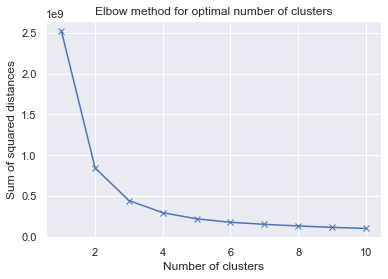

array([3, 0, 2, ..., 3, 1, 0])

In [10]:
# Kmeans Clustering
from sklearn.cluster import KMeans
ssd = []
for i in range(1, 11): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state=v)
    kmeans.fit(df_cumulative_games_filtered) 
    ssd.append(kmeans.inertia_)
plt.plot(range(1,11), ssd, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow method for optimal number of clusters')
plt.show()
kmeans = KMeans(n_clusters = 4, init = "k-means++", random_state=v)
y_kmeans = kmeans.fit_predict(df_cumulative_games_filtered)
y_kmeans

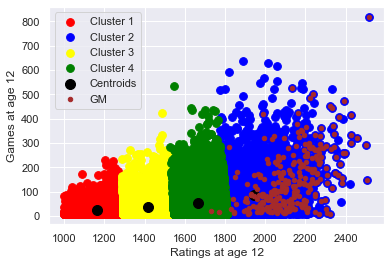

In [11]:
plt.scatter(df_cumulative_games_filtered.iloc[y_kmeans == 0, 0], df_cumulative_games_filtered.iloc[y_kmeans == 0, 1], s = 60, c = 'red', label = 'Cluster 1')
plt.scatter(df_cumulative_games_filtered.iloc[y_kmeans == 1, 0], df_cumulative_games_filtered.iloc[y_kmeans == 1, 1], s = 60, c = 'blue', label = 'Cluster 2')
plt.scatter(df_cumulative_games_filtered.iloc[y_kmeans == 2, 0], df_cumulative_games_filtered.iloc[y_kmeans == 2, 1], s = 60, c = 'yellow', label = 'Cluster 3')
plt.scatter(df_cumulative_games_filtered.iloc[y_kmeans == 3, 0], df_cumulative_games_filtered.iloc[y_kmeans == 3, 1], s = 60, c = 'green', label = 'Cluster 4')


plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'black', label = 'Centroids')
plt.scatter(df_cluster1.iloc[:,0], df_cluster1.iloc[:,1], s=20, c='brown', label='GM')
plt.xlabel('Ratings at age 12')
plt.ylabel('Games at age 12')
plt.legend()
plt.show()

In [12]:
df_cumulative_games_filtered['y_means']=y_kmeans
df_cluster2=df_cluster1.join(df_cumulative_games_filtered['y_means'], how='left')
count1=df_cluster2['y_means'].value_counts()
print('Number of GM in Blue Cluster = ' + str((np.array(count1))[0]))
print('Number of GM not in Blue Cluster = ' + str((np.array(count1))[1]))

Number of GM in Blue Cluster = 297
Number of GM not in Blue Cluster = 2


# Inference

In [13]:
quartiles = df_cumulative_games_filtered['games_under_age_limit'].quantile([0.25,0.5,0.75,1]).values
print('Quartile for games played till age 12 - ' + str(quartiles))

lower_games_fide = []
lower_s_games_fide = []
medium_games_fide = []
higher_games_fide = []

for idx,row in df_cumulative_games_filtered.iterrows():
    if row['games_under_age_limit']<=quartiles[0]:
        lower_games_fide.append(idx[0])
    elif row['games_under_age_limit']<=quartiles[1]:
        lower_s_games_fide.append(idx[0])
    elif row['games_under_age_limit']<=quartiles[2]:
        medium_games_fide.append(idx[0])
    else:
        higher_games_fide.append(idx[0])

Quartile for games played till age 12 - [ 13.  24.  51. 819.]


(array([8.580e+02, 1.052e+03, 1.118e+03, 1.046e+03, 9.550e+02, 8.420e+02,
        7.060e+02, 5.970e+02, 4.760e+02, 3.940e+02, 3.410e+02, 2.230e+02,
        1.620e+02, 1.190e+02, 6.400e+01, 3.000e+01, 1.200e+01, 6.000e+00,
        0.000e+00, 1.000e+00]),
 array([1001. , 1091.5, 1182. , 1272.5, 1363. , 1453.5, 1544. , 1634.5,
        1725. , 1815.5, 1906. , 1996.5, 2087. , 2177.5, 2268. , 2358.5,
        2449. , 2539.5, 2630. , 2720.5, 2811. ]),
 <BarContainer object of 20 artists>)

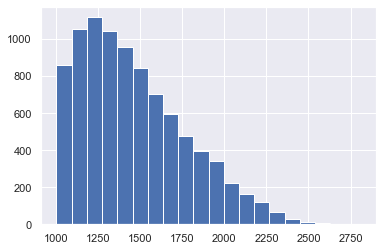

In [14]:
df_ratings.loc[lower_games_fide]['NOV-22'].mean()
plt.hist(df_ratings.loc[lower_games_fide]['NOV-22'], bins=20)

(array([310., 492., 665., 734., 703., 697., 637., 609., 520., 478., 424.,
        358., 258., 210., 147.,  94.,  56.,  50.,   9.,   9.]),
 array([1001. , 1083.8, 1166.6, 1249.4, 1332.2, 1415. , 1497.8, 1580.6,
        1663.4, 1746.2, 1829. , 1911.8, 1994.6, 2077.4, 2160.2, 2243. ,
        2325.8, 2408.6, 2491.4, 2574.2, 2657. ]),
 <BarContainer object of 20 artists>)

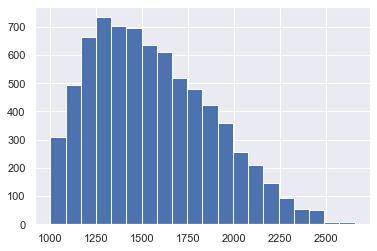

In [15]:
df_ratings.loc[lower_s_games_fide]['NOV-22'].mean()
plt.hist(df_ratings.loc[lower_s_games_fide]['NOV-22'], bins=20)

(array([184., 361., 461., 591., 658., 668., 674., 631., 608., 552., 491.,
        450., 404., 306., 227., 162., 118.,  57.,  30.,  12.]),
 array([1001.  , 1083.85, 1166.7 , 1249.55, 1332.4 , 1415.25, 1498.1 ,
        1580.95, 1663.8 , 1746.65, 1829.5 , 1912.35, 1995.2 , 2078.05,
        2160.9 , 2243.75, 2326.6 , 2409.45, 2492.3 , 2575.15, 2658.  ]),
 <BarContainer object of 20 artists>)

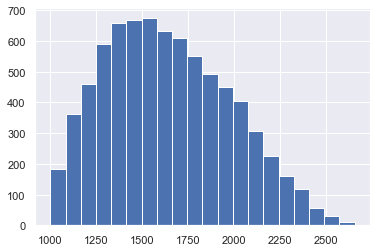

In [16]:
df_ratings.loc[medium_games_fide]['NOV-22'].mean()
plt.hist(df_ratings.loc[medium_games_fide]['NOV-22'], bins=20)

(array([ 56., 106., 236., 348., 481., 566., 619., 708., 666., 688., 689.,
        644., 595., 459., 431., 352., 198.,  95.,  57.,  17.]),
 array([1001. , 1090.2, 1179.4, 1268.6, 1357.8, 1447. , 1536.2, 1625.4,
        1714.6, 1803.8, 1893. , 1982.2, 2071.4, 2160.6, 2249.8, 2339. ,
        2428.2, 2517.4, 2606.6, 2695.8, 2785. ]),
 <BarContainer object of 20 artists>)

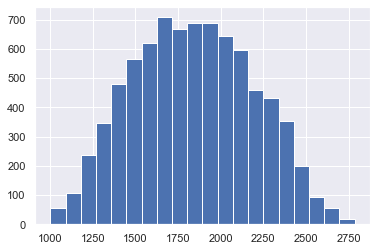

In [17]:
df_ratings.loc[higher_games_fide]['NOV-22'].mean()
plt.hist(df_ratings.loc[higher_games_fide]['NOV-22'], bins=20)

In [18]:
from statsmodels.stats.power import TTestIndPower
# parameters for power analysis
effect = 0.5
alpha = 0.005
power = 0.9
# perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect, power=power, nobs1=None, ratio=1.0, alpha=alpha, alternative='larger')
print('Sample Size: %.3f' % result)

Sample Size: 120.705


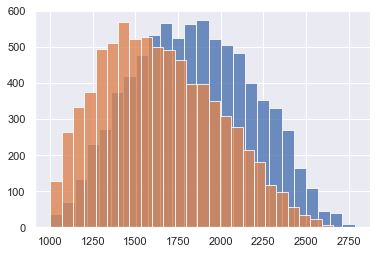

Ttest_indResult(statistic=-35.3295648107622, pvalue=1.9716633965035477e-263)

In [19]:
plt.hist(df_ratings.loc[higher_games_fide]['NOV-22'],bins=25, label='High', alpha=0.8)
plt.hist(df_ratings.loc[medium_games_fide]['NOV-22'],bins=25, label='Low', alpha=0.8)
plt.show()
stats.ttest_ind(df_ratings.loc[medium_games_fide]['NOV-22'], df_ratings.loc[higher_games_fide]['NOV-22'], alternative="less", equal_var=False)

In [20]:
# Cohen's d

def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

print('Cohens d - ')
print(cohen_d(df_ratings.loc[higher_games_fide]['NOV-22'], df_ratings.loc[medium_games_fide]['NOV-22']))

Cohens d - 
0.5643555043661611


# Classification

In [21]:
male_prof_players = df_overall.loc[(df_overall['flag']!='i') & (df_overall['flag']!='w') & (df_overall['flag']!='wi') & ((df_overall['Title_nov22']=='GM') | (df_overall['Title_nov22']=='IM'))].index.values
print(len(male_prof_players))

male_non_prof_players = df_overall.loc[(df_overall['flag']!='i') & (df_overall['flag']!='w') & (df_overall['flag']!='wi') & (df_overall['Title_nov22']!='GM') & (df_overall['Title_nov22']!='IM')].index.values
print(len(male_non_prof_players))

3611
142082


In [22]:
# Extracting Ratings of professional players
df_ratings['rating_at_age_limit'] = pd.Series(dtype='float64')
data_dict = {}

for idx, row in df_ratings.loc[male_prof_players].iterrows():
    yob = idx[1]
    if (yob<1990 or yob>2005):
        continue
    else:
        month = "JAN"
        year = str(yob+age_limit+1)[-2:]
        if (int(year)>22):
            year="22"
        rating_from = month+"-"+str(yob)[-2:]
        if (datetime.strptime(rating_from, "%b-%y")<datetime.strptime("JAN-01", "%b-%y")):
            rating_from = "JAN-01"
        rating_till = month+"-"+year
        data_dict[idx[0]] = row[rating_from:rating_till]   

In [23]:
df_ratings_gm = pd.DataFrame.from_dict(data_dict, orient='index')
df_ratings_gm['label'] = 1

In [24]:
# Extracting Ratings of non-professional players
data_dict = {}
for idx, row in df_ratings.loc[male_non_prof_players].iterrows():
    yob = idx[1]
    if (yob<1990 or yob>2005):
        continue
    else:
        month = "JAN"
        year = str(yob+age_limit+1)[-2:]
        if (int(year)>22):
            year="22"
        rating_from = month+"-"+str(yob)[-2:]
        if (datetime.strptime(rating_from, "%b-%y")<datetime.strptime("JAN-01", "%b-%y")):
            rating_from = "JAN-01"
        rating_till = month+"-"+year
        data_dict[idx[0]] = row[rating_from:rating_till]

In [25]:
df_ratings_nongm = pd.DataFrame.from_dict(data_dict, orient='index')
timesorted_columns = sorted(list(df_ratings_nongm.columns.values), key= lambda x: datetime.strptime(x, "%b-%y"))
df_ratings_nongm = df_ratings_nongm[timesorted_columns]
df_ratings_nongm['label'] = 0
df_ratings_gm.shape

(1099, 120)

In [26]:
df_cumulative_games = df_num_games.cumsum(axis=1)
df_cumulative_games = df_cumulative_games.join(df_overall[['Dob','mean']], how="inner")
df_cumulative_games = df_cumulative_games.dropna(subset=["mean"],axis=0)
df_cumulative_games = df_cumulative_games.reset_index().set_index(["fide_id", "Dob"])

In [27]:
# Cumulative games under age limit
df_cumulative_games['games_under_age_limit'] = pd.Series(dtype='float64')
age_limit = 12
cum_games_under_age = []

for idx,row in df_cumulative_games.iterrows():
    yob = idx[1]
    if (yob<1992 or yob>2002):
        continue
    else:
        month = "JUL"
        year = str(yob+age_limit+1)[-2:]
        if (int(year)>22):
            year="22"
        row['games_under_age_limit'] = (row[month+"-"+year])

In [28]:
# Data Processing
df_cumulative_games=df_cumulative_games.reset_index()
df_cumulative_games=df_cumulative_games.set_index('fide_id')

df_ratings_nongm = df_ratings_nongm.sample(frac=0.2, replace=False)

df_ratings_combined = pd.concat([df_ratings_gm, df_ratings_nongm], axis=0)

df_ratings_combined = df_ratings_combined.dropna(axis=0, how='any', thresh=2)
df_ratings_combined= df_ratings_combined.join(df_cumulative_games['games_under_age_limit'], how='left')

In [29]:
y = df_ratings_combined['label']
df_ratings_combined = df_ratings_combined.drop(['label'], axis=1)
df_ratings_combined = df_ratings_combined.join(df_overall['country'], how="inner")
df_ratings_combined = pd.get_dummies(df_ratings_combined)

In [30]:
# Kmeans Clustering
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_ratings_combined, y, test_size=0.1, random_state=v)

from sklearn.ensemble import HistGradientBoostingClassifier

clf = HistGradientBoostingClassifier().fit(X_train, y_train)

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

from sklearn.model_selection import cross_val_score

# Use cross-validation to evaluate the model
scores = cross_val_score(clf, df_ratings_combined, y, cv=10)

# Print the mean and standard deviation of the scores
print(f'Mean score: {scores.mean():.2f}')
print(f'Standard deviation: {scores.std():.2f}')

y_probs = clf.predict_proba(X_test)[:, 1]

              precision    recall  f1-score   support

           0       0.89      0.92      0.91       148
           1       0.84      0.80      0.82        81

    accuracy                           0.88       229
   macro avg       0.87      0.86      0.86       229
weighted avg       0.88      0.88      0.88       229

Mean score: 0.84
Standard deviation: 0.10


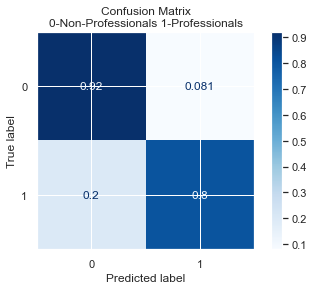

In [31]:
# Confusion matrix report
from sklearn.metrics import plot_confusion_matrix

fig = plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, normalize='true')
fig.ax_.set_title('Confusion Matrix' + '\n' +  '0-Non-Professionals 1-Professionals')
plt.show()

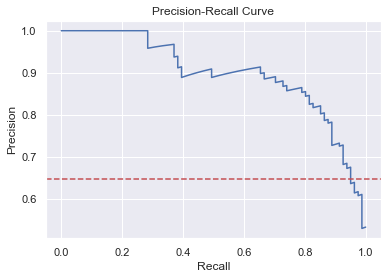

    Area under PR Curve is:  0.8966913783435957


In [32]:
# Precision recall Curve

from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Plot the precision-recall curve
plt.plot(recall, precision)
neg=y_test.value_counts(ascending = True).iloc[0]
pos=y_test.value_counts(ascending = True).iloc[1]
plt.axhline(y=pos/(pos+neg), color='r', linestyle='--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()
print("    Area under PR Curve is: ", auc(recall, precision))

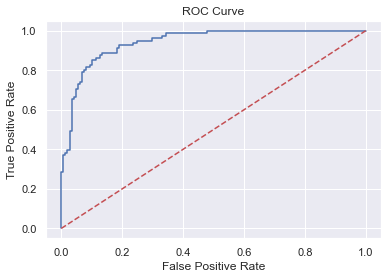

    Area under ROC Curve (AUROC):  0.9421921921921922


In [33]:
# ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Plot the ROC curve
plt.plot(fpr, tpr)
aa=np.linspace(0.0, 1.0, 100)
plt.plot(aa, aa, 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print("    Area under ROC Curve (AUROC): ", auc(fpr, tpr))

# Prediction

In [34]:
# Data Prep
df_ratings_combined = pd.concat([df_ratings_gm, df_ratings_nongm], axis=0)
df_ratings_combined = df_ratings_combined.join(df_overall[['country', 'Dob']], how="inner")

In [35]:
df_ratings_combined = df_ratings_combined.dropna(axis=0, how='any', thresh=2)
df_ratings_combined = df_ratings_combined.join(df_cumulative_games['NOV-22'], how="inner")
df_ratings_combined['Dob'] = df_ratings_combined['Dob'].astype('object')
df_ratings_combined = pd.get_dummies(df_ratings_combined)

In [36]:
y = df_ratings.loc[df_ratings_combined.loc[df_ratings_combined.label==1].index]['NOV-22'].values
df_ratings_combined = df_ratings_combined.loc[df_ratings_combined.label==1]
df_ratings_combined = df_ratings_combined.drop("label", axis=1)

In [37]:
df_ratings_combined = df_ratings_combined.fillna(method='pad', axis=1)
df_ratings_combined = df_ratings_combined.fillna(method='bfill', axis=1)

In [38]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(df_ratings_combined, y, test_size=0.2, random_state=v)

In [63]:
# Random Forest regressor

parameters = {'n_estimators': randint(100,1000),
              'max_depth'    : randint(50,200),
              'min_samples_split': uniform(0,1)
             }


clf = RandomForestRegressor()
randm_src = RandomizedSearchCV(clf, parameters, n_iter=10)
randm_src.fit(X_train,y_train)

RandomizedSearchCV(estimator=RandomForestRegressor(),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002780EACD700>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002780BCD2370>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002780E941100>})

In [64]:
randm_src.best_estimator_

RandomForestRegressor(max_depth=175, min_samples_split=0.261748338263016,
                      n_estimators=547)

In [40]:
cval = []
for idx,val in enumerate(df_ratings_combined.columns.values):
    if ("country" in val):
         cval.append(idx)
            
            
print("Feature importance of all rating columns: ", sum(randm_src.best_estimator_.feature_importances_[:120]))
print("Feature importance of all country columns: ", sum(randm_src.best_estimator_.feature_importances_[cval]))

Feature importance of all rating columns:  0.8883813237191907
Feature importance of all country columns:  0.10319233607183308


In [41]:
y_pred = randm_src.predict(X_test)
print(mean_squared_error(y_test, y_pred, squared=False))
print(mean_absolute_percentage_error(y_test, y_pred))

92.15651354600271
0.027432585883528874


[]

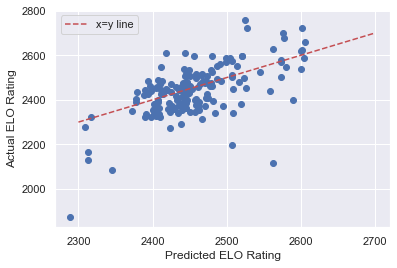

In [42]:
plt.scatter(y_pred, y_test)
plt.xlabel("Predicted ELO Rating")
plt.ylabel("Actual ELO Rating")
plt.plot(np.linspace(2300, 2700, 500), np.linspace(2300, 2700, 500), label="x=y line", ls="--", color="r")
plt.legend()
plt.plot()

In [51]:
# Hist Gradient boosting regressor

randm_src = HistGradientBoostingRegressor()
randm_src.fit(X_train,y_train)

HistGradientBoostingRegressor()

In [52]:
y_pred = randm_src.predict(X_test)
print(mean_squared_error(y_test, y_pred, squared=False))
print(mean_absolute_percentage_error(y_test, y_pred))

102.7616367988206
0.032055313773039384


# Extra Credit

In [43]:

df_ratings_gm = df_ratings_gm.drop('label', axis=1)
df_ratings_prof = df_ratings.loc[df_ratings_gm.index]

In [44]:
peaking_age = []
for idx, row in df_ratings_prof.iterrows():
    peak_year = datetime.strptime(df_ratings_prof.columns[np.argmax(row)], "%b-%y")
    diff = (peak_year - datetime.strptime(str(idx[1]), "%Y"))
    peaking_age.append(diff.days/365)

Text(0, 0.5, 'Frequency')

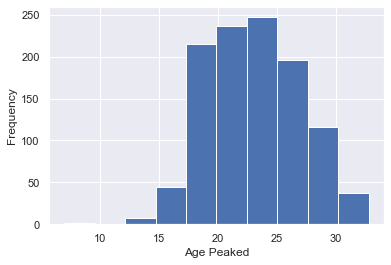

In [45]:
plt.hist(peaking_age)
plt.xlabel("Age Peaked")
plt.ylabel("Frequency")

In [46]:
print('Mean= ' + str(np.mean(peaking_age)))

Mean= 23.076433121019107
